<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/WeightStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
import os
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

In [2]:
# Set plotting style at module level
plt.rcParams.update({
    # Font sizes
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'legend.frameon': False,  # No box around legend
    'axes.grid': False,
    # Tick settings
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Data

In [4]:
def combine_data(datasets, tags_to_combine, new_tag, delete_old_tags=True):
    """
    Combines subdicts of the 'datasets' dict.

    Inputs:
        datasets: dict that maps {dataset_tag : dataset_dict}
        tags_to_combine: list if strings [dataset_tag1, ..., dataset_tagN] of the tags to be combined
        new_tag: the name of the new tag of the combined subdict

    Returns:
        datasets: same datasets dict as input, but with the specified tags combined.
    """

    # initialize empty lists for new tag
    datasets[new_tag] = {key: [] for key in datasets[tags_to_combine[0]].keys()}

    # Loop through old tags and append np arrays to lists
    for tag in tags_to_combine:
        for key, value in datasets[tag].items():
            datasets[new_tag][key].append(value)

    # Concatenate lists into single np array
    for key, value in datasets[new_tag].items():
        datasets[new_tag][key] = np.concatenate(value, axis=0)

    # Delete old tags
    if delete_old_tags:
        for tag in tags_to_combine:
            del datasets[tag]

    # Make sure everything is an np array
    for tag, data_dict in datasets.items():
        for key, value in data_dict.items():
            data_dict[key] = np.array(value)

    return datasets

In [5]:
# Load the data

datasets = {} # dictionary of dictionaries, each dictionary is a dataset

# base_dir = '/kaggle/input/addata/ADdata'
base_dir = '/content/drive/MyDrive/Datasets/ADdata'

# loop over all the files in the base directory
for tag in os.listdir(base_dir):
    file_path = os.path.join(base_dir, tag)

    datasets[tag] = {}

    # load the data from the file
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            datasets[tag][key] = hf[key][:]

# Print the shape of the data
for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB25_500306.h5:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_HLT_unprescaled: (1017586,)
  pass_L1AD: (1017586,)
  pass_L1_unprescaled: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
MC_HAHMggf_470000.h5:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_onli

In [6]:
# Remove EB24 data
for tag in [key for key in datasets.keys()]:
    if tag.startswith('EB24'):
        del datasets[tag]

# Rename EB25 to EB_test
datasets['EB_test'] = datasets.pop('EB25_500306.h5')

In [7]:
# Change pass_HLT_unprescaled to boolean and add weights for MC
for tag, data_dict in datasets.items():
    data_dict['passHLT'] = data_dict['pass_HLT_unprescaled']==1
    del data_dict['pass_HLT_unprescaled']

    data_dict['passL1'] = data_dict['pass_L1_unprescaled']==1
    del data_dict['pass_L1_unprescaled']

    if tag.startswith('MC'):
        data_dict['weights'] = np.ones(len(data_dict['run_numbers']))

Except for ```EB_test```, all the other classes have been weighted 1.0



In [8]:
# Rename the MC tags for clarity

original_tags = [tag for tag in datasets.keys()]

for tag in original_tags:
    if tag.startswith('MC'):
        new_tag = tag.split('MC_')[1]
        new_tag = new_tag.split('_470000')[0]

        if new_tag == 'hh':
            new_tag = 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'

        datasets[new_tag] = datasets.pop(tag)

for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB_test:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_L1AD: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
  passHLT: (1017586,)
  passL1: (1017586,)
HAHMggf:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_online: (100000,)
  passL1ADT_online: (100000,)
  

In [9]:
HLT_data_tags = [tag for tag in datasets.keys() if not tag.startswith('MC')]

In [10]:
print(HLT_data_tags)

['EB_test', 'HAHMggf', 'HNLeemu', 'HtoSUEP', 'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu', 'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1']


In [11]:
# Define column names for HLT_data
columns = ['j0pt', 'j0eta', 'j0phi', 'j1pt', 'j1eta', 'j1phi',
           'j2pt', 'j2eta', 'j2phi', 'j3pt', 'j3eta', 'j3phi',
           'j4pt', 'j4eta', 'j4phi', 'j5pt', 'j5eta', 'j5phi',
           'e0pt', 'e0eta', 'e0phi', 'e1pt', 'e1eta', 'e1phi',
           'e2pt', 'e2eta', 'e2phi', 'mu0pt', 'mu0eta', 'mu0phi',
           'mu1pt', 'mu1eta', 'mu1phi', 'mu2pt', 'mu2eta', 'mu2phi',
           'ph0pt', 'ph0eta', 'ph0phi', 'ph1pt', 'ph1eta', 'ph1phi',
           'ph2pt', 'ph2eta', 'ph2phi', 'METpt', 'METeta', 'METphi']

In [12]:
combined_hlt_df = pd.concat([
    pd.DataFrame(datasets[tag]['HLT_data'], columns=columns)
      .assign(weight=np.asarray(datasets[tag]['weights']).reshape(-1), target=tag)
    for tag in datasets
], ignore_index=True)
combined_hlt_df.head()

,j0pt,j0eta,j0phi,j1pt,j1eta,j1phi,j2pt,j2eta,j2phi,j3pt,...,ph1eta,ph1phi,ph2pt,ph2eta,ph2phi,METpt,METeta,METphi,weight,target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.009135,0.0,-1.915390,5.0,EB_test
1,23.893738,-0.032734,1.230678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.742011,0.0,-1.910914,5.0,EB_test
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,EB_test
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.936713,0.0,-0.541381,12.0,EB_test
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,5.0,EB_test


### Some details of the dataset

```
My data is in a pandas dataframe, combined_hlt_df. 48 features and 1 target variable called 'target' and 1 column 'weight' containing weights for the respective events (rows).
target
EB_test                               1017586
HAHMggf                                100000
HNLeemu                                100000
HtoSUEP                                100000
VBF_H125_a55a55_4b_ctau1_filtered      100000
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1         50000
Znunu                                   10000
ggF_H125_a16a16_4b_ctau10_filtered      10000
Name: count, dtype: int64
```



## Exploratory Data Visualisation

How many events are assigned a METpt?

Total number of events with non-zero METpt: 1042248

Number of events with non-zero METpt for each target:
target
EB_test                               624643
VBF_H125_a55a55_4b_ctau1_filtered      98561
HtoSUEP                                88288
HNLeemu                                82614
HAHMggf                                78684
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1        49615
ggF_H125_a16a16_4b_ctau10_filtered     10000
Znunu                                   9843
Name: count, dtype: int64


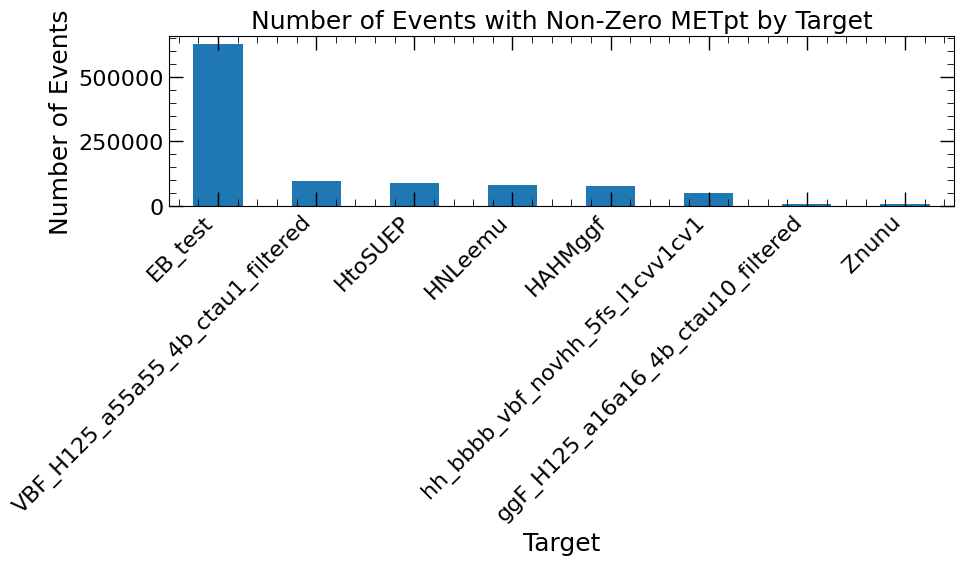

In [13]:
# Count total number of events with non-zero METpt
total_non_zero_METpt = (combined_hlt_df['METpt'] != 0).sum()

# Count number of events with non-zero METpt for each target
non_zero_METpt_by_target = combined_hlt_df[combined_hlt_df['METpt'] != 0]['target'].value_counts()

print(f"Total number of events with non-zero METpt: {total_non_zero_METpt}")
print("\nNumber of events with non-zero METpt for each target:")
print(non_zero_METpt_by_target)

# Plot a bar graph of the counts
plt.figure(figsize=(10, 6))
non_zero_METpt_by_target.plot(kind='bar')
plt.title('Number of Events with Non-Zero METpt by Target')
plt.xlabel('Target')
plt.ylabel('Number of Events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

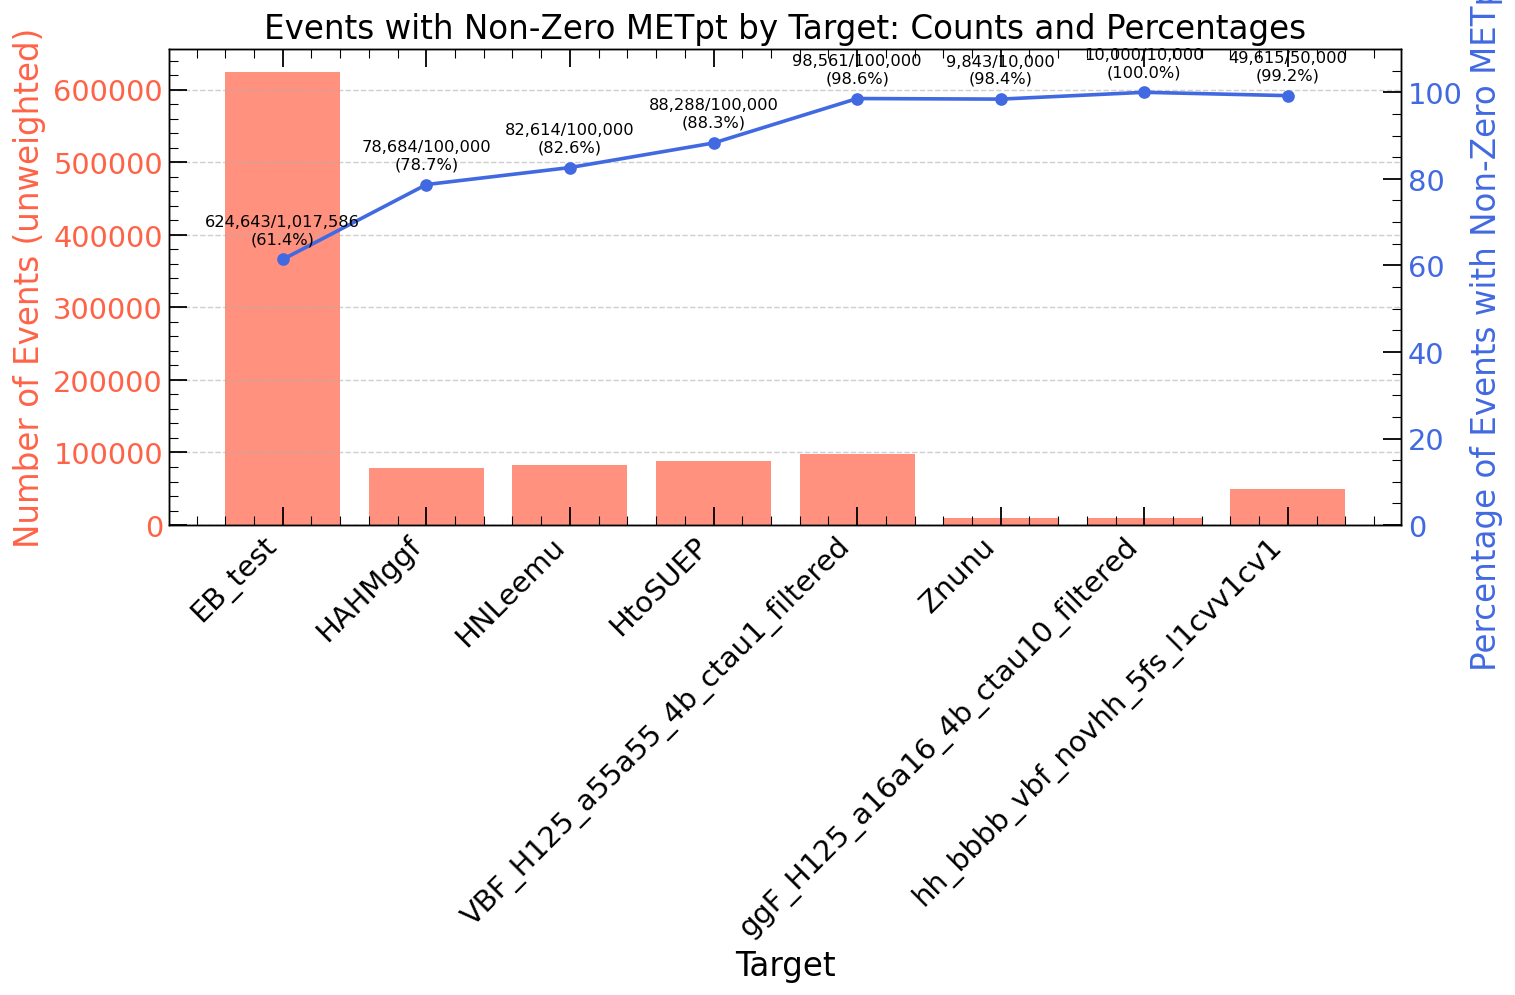

In [14]:
# Count total number of events per target
total_events_by_target = combined_hlt_df['target'].value_counts().sort_index()

# Count number of events with non-zero METpt per target
non_zero_METpt_by_target = combined_hlt_df[combined_hlt_df['METpt'] != 0]['target'].value_counts().sort_index()

# Compute percentage of non-zero METpt events per target
percent_non_zero_METpt = (non_zero_METpt_by_target / total_events_by_target * 100)

# --- Combined plot ---
fig, ax1 = plt.subplots(figsize=(12, 8),dpi=130)

# Left y-axis: counts
bars = ax1.bar(
    non_zero_METpt_by_target.index,
    non_zero_METpt_by_target.values,
    color='tomato',
    alpha=0.7,
    label='Number of Events'
)
ax1.set_xlabel('Target')
ax1.set_ylabel('Number of Events (unweighted)', color='tomato')
ax1.tick_params(axis='y', labelcolor='tomato')

# Rotate x-axis labels
plt.xticks(ticks=range(len(non_zero_METpt_by_target.index)),
           labels=non_zero_METpt_by_target.index,
           rotation=45, ha='right')

# Enable grid only on ax1
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)

# Right y-axis: percentage
ax2 = ax1.twinx()
ax2.plot(
    percent_non_zero_METpt.index,
    percent_non_zero_METpt.values,
    color='royalblue',
    marker='o',
    linewidth=2,
    label='Percentage of Events'
)
ax2.set_ylabel('Percentage of Events with Non-Zero METpt (%)', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')
ax2.set_ylim(0, 110)
ax2.grid(False)

# Annotate each point with both percentage and counts
for i, (count, total, pct) in enumerate(zip(
    non_zero_METpt_by_target.values,
    total_events_by_target.values,
    percent_non_zero_METpt.values
)):
    ax2.text(
        i, pct + 3,
        f'{count:,}/{total:,}\n({pct:.1f}%)',  # formatted nicely with commas
        ha='center', va='bottom',
        fontsize=9, color='black'
    )

# Title and layout
plt.title('Events with Non-Zero METpt by Target: Counts and Percentages')
fig.tight_layout()
plt.show()


In [15]:
# Define the target name you want to filter by
target_name = 'EB_test'
filtered_df = combined_hlt_df[combined_hlt_df['target'] == target_name].drop(['target', 'weight'], axis=1)

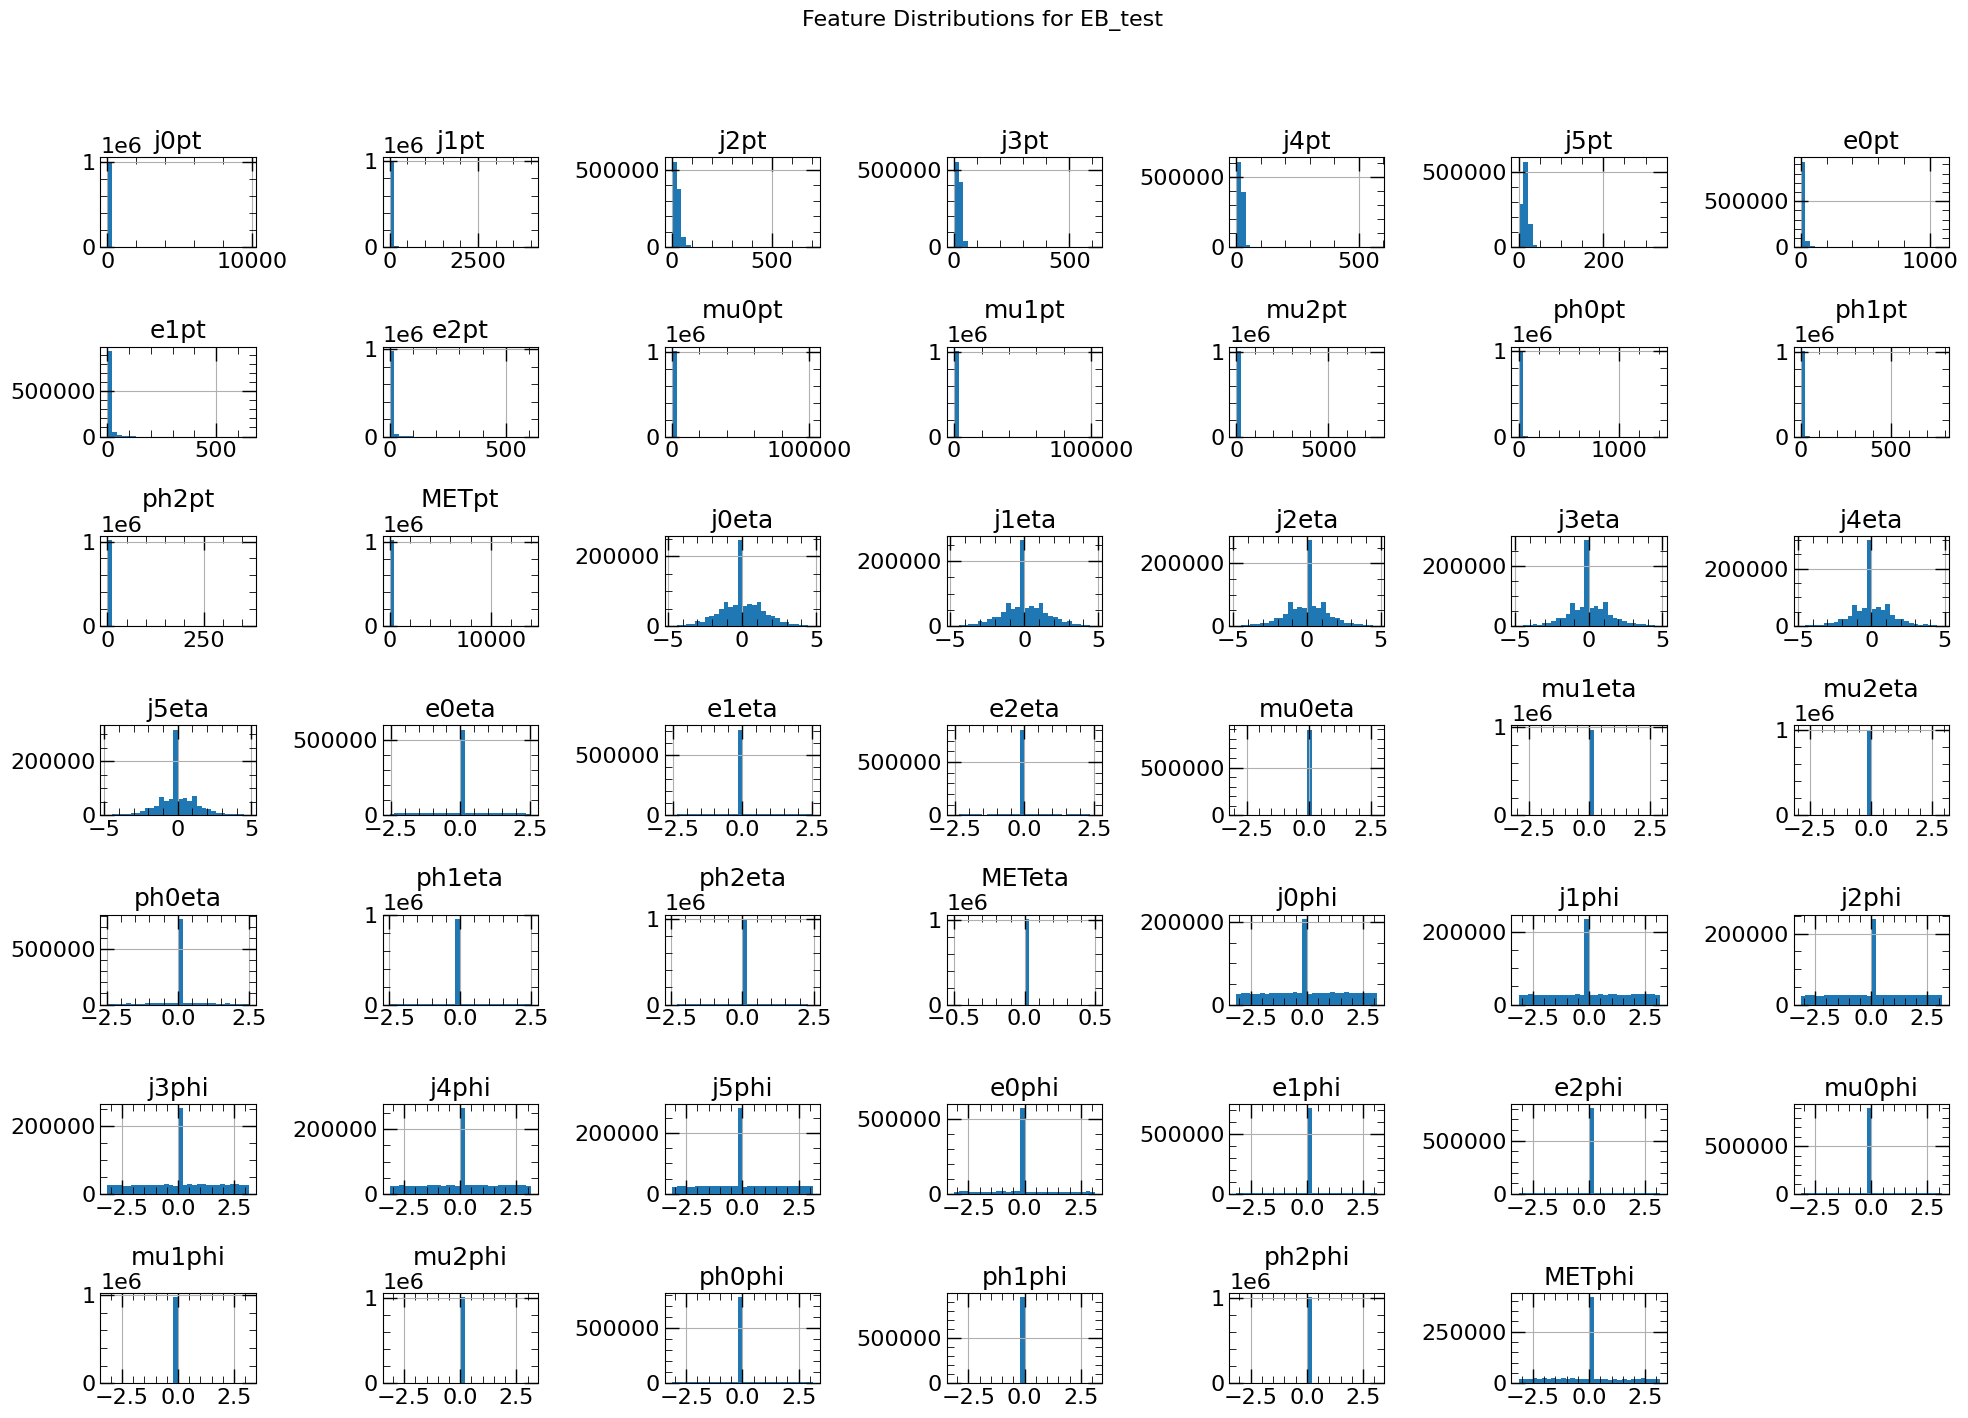

In [16]:
# Plot histograms directly from the filtered and dropped DataFrame
# Quick and Simple plot
# combined_hlt_df[combined_hlt_df['target'] == target_name].drop('target', axis=1).hist(figsize=(20,15), bins=30)

# plt.suptitle(f'Feature Distributions for {target_name}')
# plt.tight_layout()
# plt.show()


# Filter data for the selected target
df_target = filtered_df

# Define feature groups based on name patterns
pt_cols = [c for c in df_target.columns if 'pt' in c]
eta_cols = [c for c in df_target.columns if 'eta' in c]
phi_cols = [c for c in df_target.columns if 'phi' in c]
# met_cols = [c for c in df_target.columns if 'MET' in c]
other_cols = ['weight'] if 'weight' in df_target.columns else []

# Combine in desired order
ordered_cols = pt_cols + eta_cols + phi_cols + other_cols

# Plot histograms grouped by type
df_target[ordered_cols].hist(
    figsize=(20, 15),
    bins=30,
)

plt.suptitle(f'Feature Distributions for {target_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Let's study the weights

Unique values of weight for events with weight < 600000:
[5.00000e+00 1.20000e+01 4.53438e+05 4.93448e+05 1.37406e+04 5.49622e+04
 6.32645e+02 6.04841e+02 1.09926e+04 1.07324e+04 4.90204e+04 3.75770e+01
 1.33364e+04 6.11560e+02 6.04036e+02 1.00000e+01 6.31765e+02 2.00000e+02
 6.40000e+02 6.10737e+02 4.99996e+00 1.00000e+00]


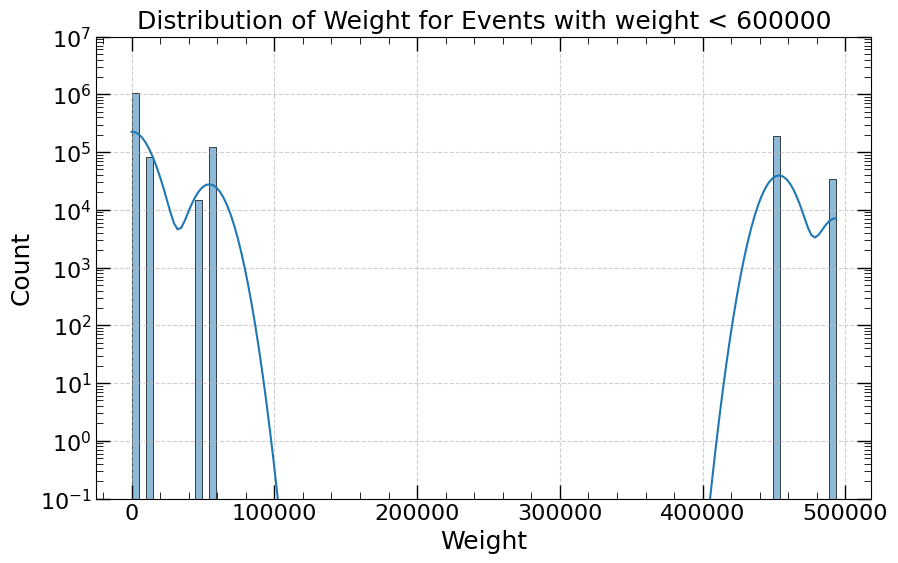

In [17]:
# Filter the DataFrame for weights less than 200000
w = 600000
filtered_weight_df = combined_hlt_df[combined_hlt_df['weight'] < w].copy()

# Print the unique values of the filtered weights
print(f"Unique values of weight for events with weight < {w}:")
print(filtered_weight_df['weight'].unique())

# Plot the histogram of the filtered weights
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_weight_df, x='weight', bins=100, kde=True)
plt.title(f'Distribution of Weight for Events with weight < {w}')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.ylim(0.1,1e7)
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log') # Set y-axis to log scale
plt.show()

Total number of events with weight > 400000: 225382


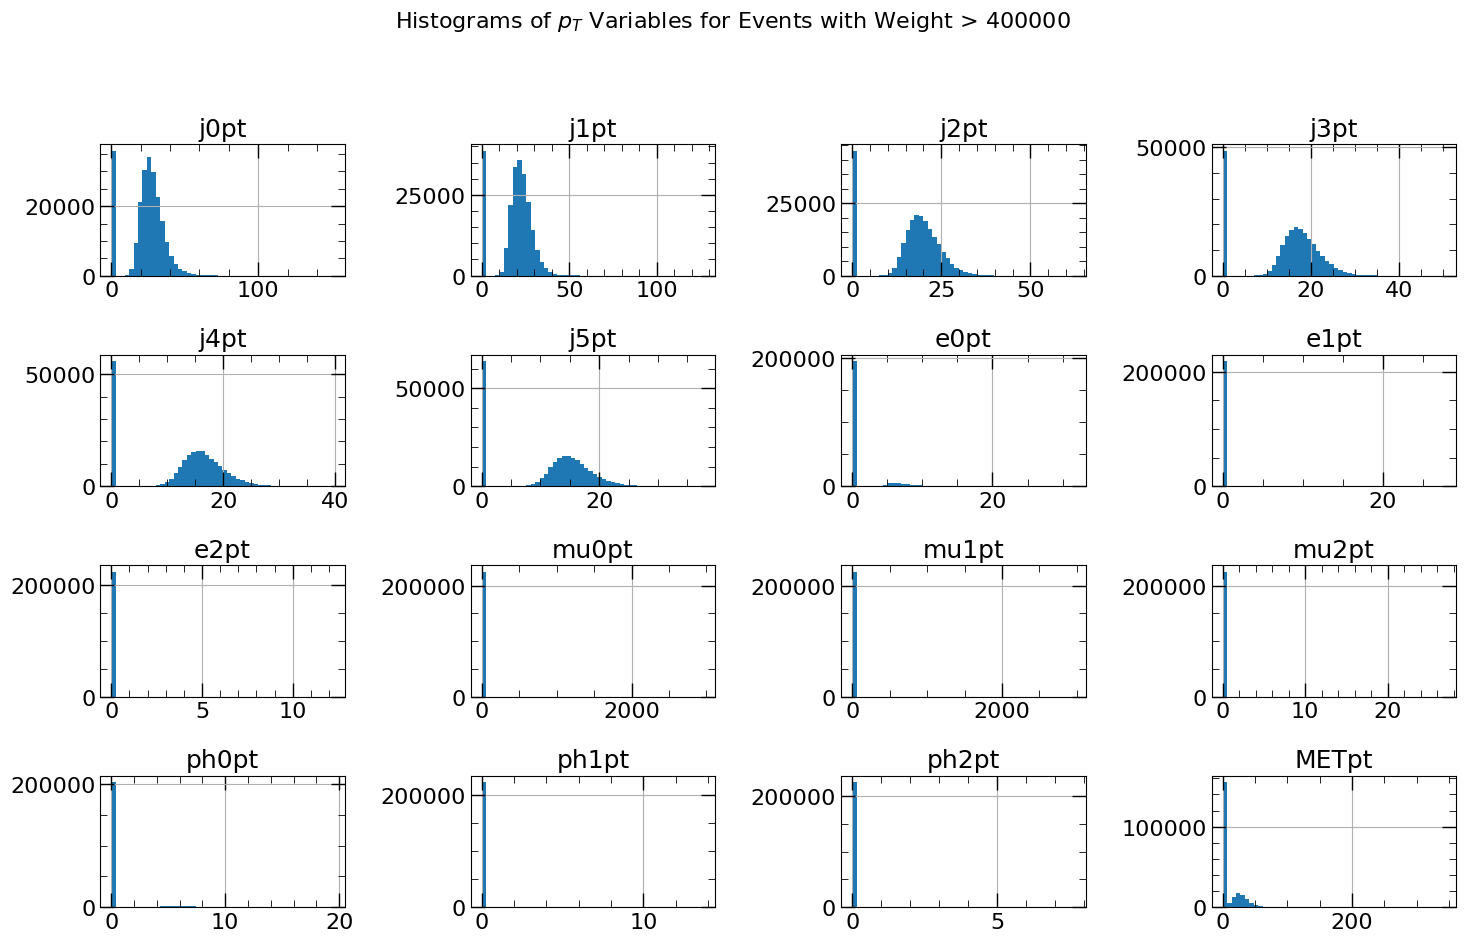

In [18]:
# Filter events with weight > 400000
high_weight_df = combined_hlt_df[combined_hlt_df['weight'] > 400000].copy()

# Print the total number of events with weight > 400000
print(f"Total number of events with weight > 400000: {len(high_weight_df)}")

# Select only the 'pt' columns for plotting
pt_cols_to_plot = [c for c in high_weight_df.columns if 'pt' in c]

# Exclude 'pt' columns where all values are zero in the filtered data
pt_cols_to_plot = [c for c in pt_cols_to_plot if not (high_weight_df[c] == 0).all()]


if not high_weight_df.empty and pt_cols_to_plot:
    # Plot histograms of the selected 'pt' columns
    high_weight_df[pt_cols_to_plot].hist(figsize=(15, 10), bins=50)
    plt.suptitle('Histograms of $p_T$ Variables for Events with Weight > 400000', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif high_weight_df.empty:
    print("No events found with weight > 400000.")
else:
    print("No non-zero 'pt' columns found in the filtered data.")

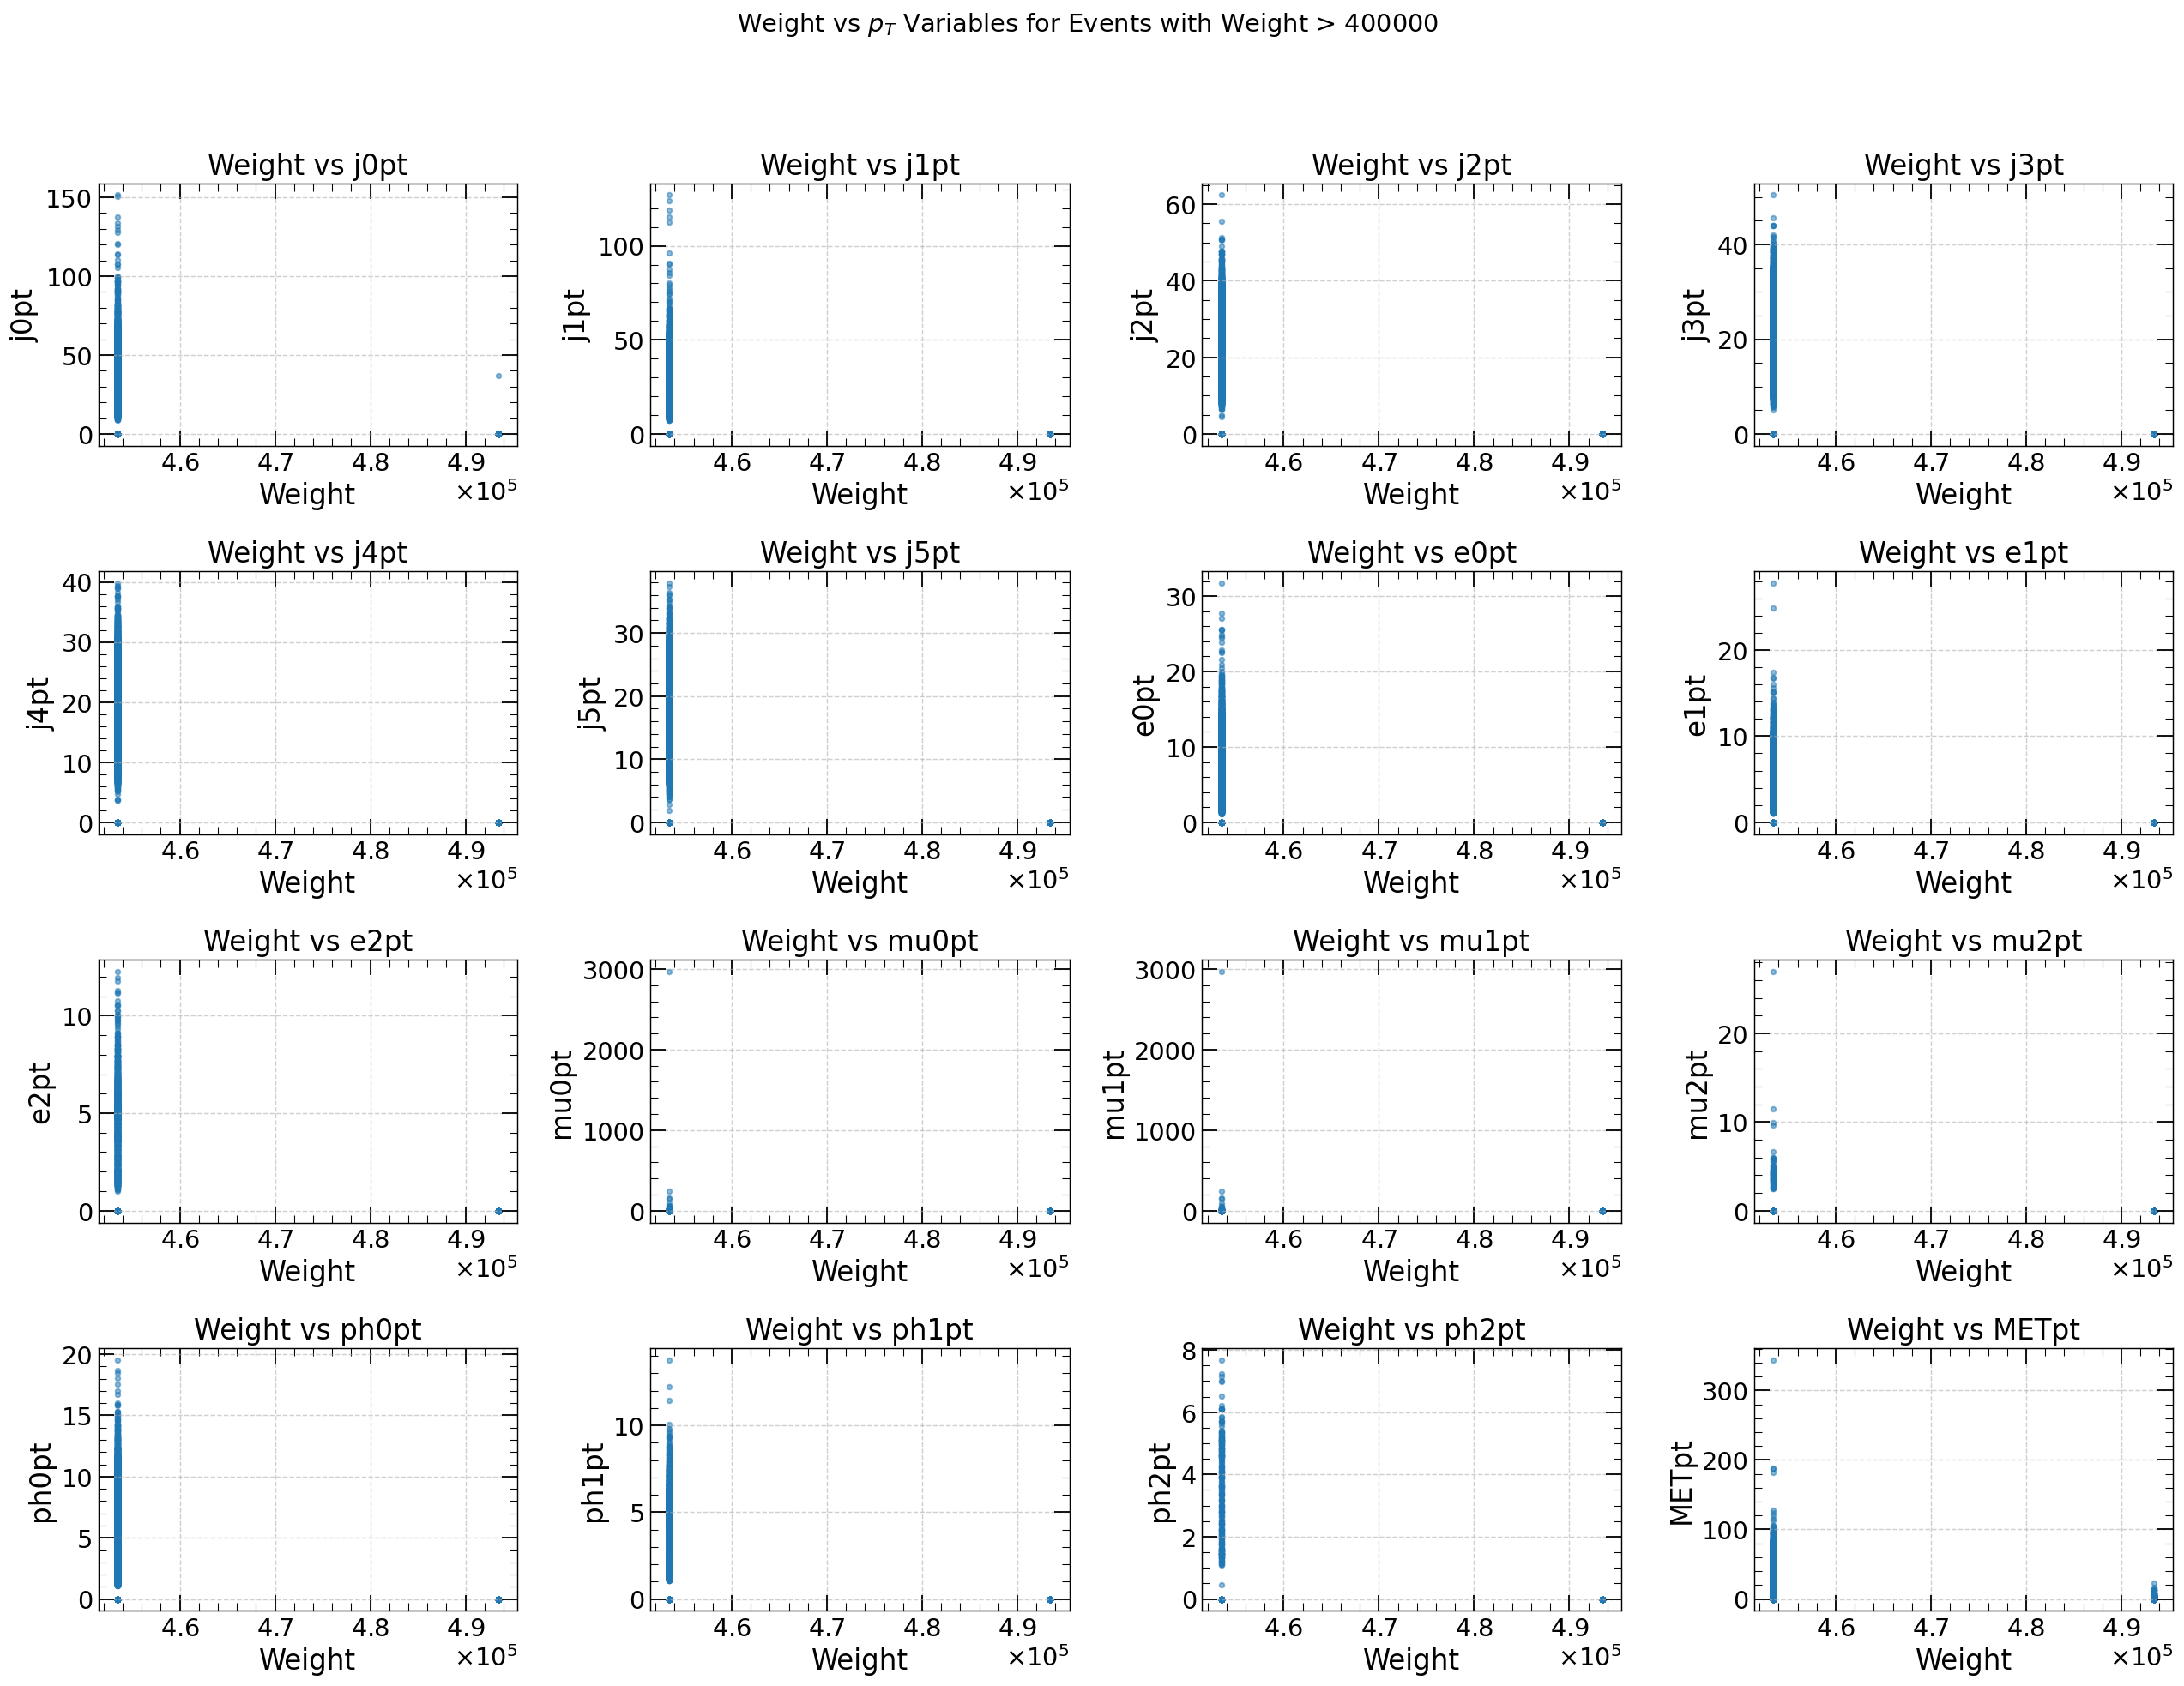

In [19]:
import matplotlib.ticker as mticker

if not high_weight_df.empty and pt_cols_to_plot:
    # Create a relative weight column to make the x-axis readable
    # high_weight_df['weight_rel'] = high_weight_df['weight'] - high_weight_df['weight'].min()

    num_pt_cols = len(pt_cols_to_plot)
    n_cols = 4  # Number of columns in the subplot grid
    n_rows = (num_pt_cols + n_cols - 1) // n_cols  # Number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), dpi=130)
    axes = axes.flatten()  # Flatten for easy iteration

    for i, pt_col in enumerate(pt_cols_to_plot):
        ax = axes[i]

        # Plot using relative weights on x-axis
        ax.scatter(high_weight_df['weight'], high_weight_df[pt_col], s=10, alpha=0.5)

        # Labels and title
        ax.set_xlabel('Weight')
        ax.set_ylabel(pt_col)
        ax.set_title(f'Weight vs {pt_col}')

        # Grid and scientific notation for neatness
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Hide unused subplots
    for j in range(num_pt_cols, len(axes)):
        fig.delaxes(axes[j])

    # Global title and layout
    plt.suptitle(r'Weight vs $p_T$ Variables for Events with Weight > 400000', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the figure
    plt.show()

elif high_weight_df.empty:
    print("No events found with weight > 400000.")
else:
    print("No non-zero 'pt' columns found in the filtered data.")


## Effective Sample size of the dataset

### What this code does:

- Computes **Kish ESS** for each class:

  $$
  n_{\text{eff}} = \frac{(\sum_i w_i)^2}{\sum_i w_i^2}
  $$

- Prints a clear **summary table** with counts, sums, and ESS.



Overall Effective Sample Size (ESS): 261,871
Raw event count: 1,487,586
Sum of weights: 112,198,863,150.86
Sum of weights²: 48,071,693,563,705,984.00

                                          count              sum_w  \
target                                                               
EB_test                            1,017,586.00 112,198,393,150.86   
HAHMggf                              100,000.00         100,000.00   
HNLeemu                              100,000.00         100,000.00   
HtoSUEP                              100,000.00         100,000.00   
VBF_H125_a55a55_4b_ctau1_filtered    100,000.00         100,000.00   
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1       50,000.00          50,000.00   
Znunu                                 10,000.00          10,000.00   
ggF_H125_a16a16_4b_ctau10_filtered    10,000.00          10,000.00   

                                                      sum_w2        ESS  \
target                                                                  

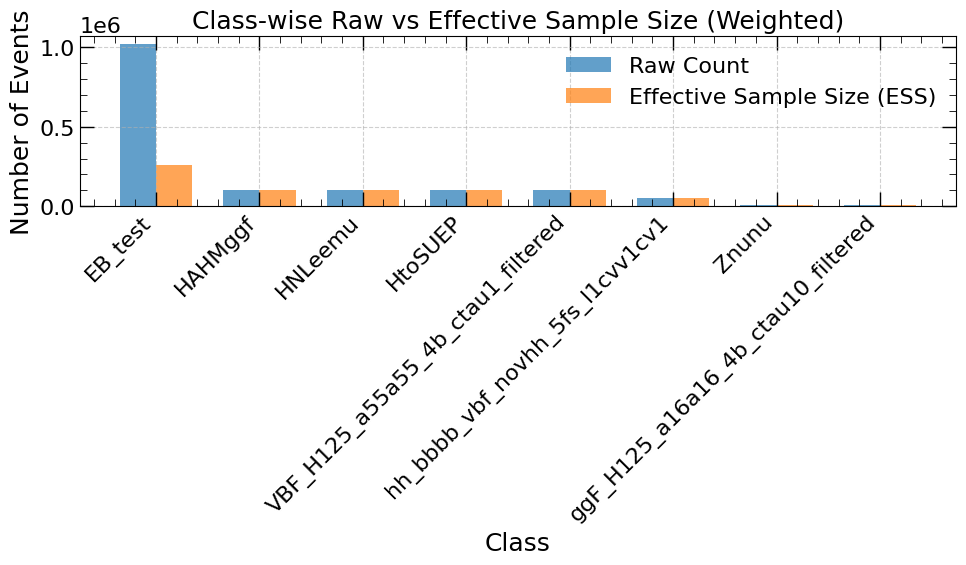

In [20]:
# ---------------------------------------------------------
# Function: Kish Effective Sample Size
# ---------------------------------------------------------
def effective_sample_size_from_weights(w):
    """Compute effective sample size (ESS) using Kish's formula."""
    w = np.asarray(w, dtype=float)
    w = w[np.isfinite(w)]  # remove NaN / inf
    sum_w = np.sum(w)
    sum_w2 = np.sum(w**2)
    return (sum_w ** 2) / sum_w2 if sum_w2 > 0 else 0.0


# ---------------------------------------------------------
# Overall Effective Sample Size
# ---------------------------------------------------------
weights = combined_hlt_df['weight']
sum_w = weights.sum()
sum_w2 = np.sum(weights**2)
n_eff_overall = (sum_w ** 2) / sum_w2 if sum_w2 > 0 else 0.0

print(f"\nOverall Effective Sample Size (ESS): {n_eff_overall:,.0f}")
print(f"Raw event count: {len(weights):,}")
print(f"Sum of weights: {sum_w:,.2f}")
print(f"Sum of weights²: {sum_w2:,.2f}\n")


# ---------------------------------------------------------
# Per-Class Effective Sample Size
# ---------------------------------------------------------
per_class_stats = (
    combined_hlt_df
    .groupby('target', group_keys=False, observed=True)   # safer grouping
    .apply(lambda g: pd.Series({
        'count': len(g),
        'sum_w': g['weight'].sum(),
        'sum_w2': (g['weight']**2).sum(),
        'ESS': effective_sample_size_from_weights(g['weight'])
    }), include_groups=False)
    .sort_values('ESS', ascending=False)
)

# Add a normalized ESS metric (ESS / raw count)
per_class_stats['ESS_per_count'] = per_class_stats['ESS'] / per_class_stats['count']

# Display neatly
pd.set_option('display.float_format', '{:,.2f}'.format)
print(per_class_stats)

# ---------------------------------------------------------
# Plot: Raw count vs Effective Sample Size
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(per_class_stats))
width = 0.35  # bar width

ax.bar(x - width/2, per_class_stats['count'], width, label='Raw Count', alpha=0.7)
ax.bar(x + width/2, per_class_stats['ESS'], width, label='Effective Sample Size (ESS)', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(per_class_stats.index, rotation=45, ha='right')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Events')
ax.set_title('Class-wise Raw vs Effective Sample Size (Weighted)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Optional: save stats
# ---------------------------------------------------------
# per_class_stats.to_csv("effective_sample_sizes.csv")


## Creating the falling background

In [21]:
# @title
def plot_weighted_distributions(df, target_name, variable, nbins=1000):
    """
    Plots weighted and unweighted distributions of a variable for a given target.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        target_name (str): The name of the target class to filter.
        variable (str): The name of the variable to plot.
    """
    # Filter by target
    df_target = df[df['target'] == target_name].copy()

    if df_target.empty:
        print(f"No data found for target: {target_name}")
        return

    # Ensure weights are numeric and handle potential issues
    df_target['weight'] = pd.to_numeric(df_target['weight'], errors='coerce').fillna(0)
    df_target = df_target[df_target['weight'] > 0].copy()  # Filter out zero weights if any

    if df_target.empty:
        print(f"No weighted data found for target: {target_name}")
        return

    sum_w = df_target['weight'].sum()
    n_events = len(df_target)

    if sum_w == 0 or n_events == 0:
        print(f"Insufficient data for plotting for target: {target_name}")
        return

    # Calculate densities
    df_target['density_1'] = np.ones_like(df_target[variable])
    df_target['density_w_sum_w'] = df_target['weight'] / sum_w
    df_target['density_1_sum_w'] = 1.0 / sum_w

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot weighted and unweighted distributions
    sns.histplot(
        data=df_target, x=variable, weights='density_1', element='step', fill=False,
        kde=False, stat='count', common_norm=False, linestyle = '--',
        label='Density = 1', color='skyblue', alpha=0.9, bins=nbins
    )

    sns.histplot(
        data=df_target, x=variable, weights='density_w_sum_w', element='step', fill=False,
        kde=False, stat='count', common_norm=False,
        label='Density = weight / sum(weight)', color='salmon', alpha=0.6, bins=nbins
    )

    sns.histplot(
        data=df_target, x=variable, weights='density_1_sum_w', element='step', fill=False,
        kde=False, stat='count', common_norm=False,
        label='Density = 1 / sum(weight)', color='lightgreen', alpha=0.4, bins=nbins
    )

    # sns.histplot(
    #     data=df_target, x=variable, weights=None, element='step', fill=False,
    #     kde=False, stat='count', common_norm=False,
    #     label='weights', color='blue', alpha=0.7, bins=nbins
    # )

    # Final formatting
    plt.xlim(-0.1,250)
    # plt.ylim(0, 0.1)
    plt.title(f'Distribution of {variable} for {target_name}')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

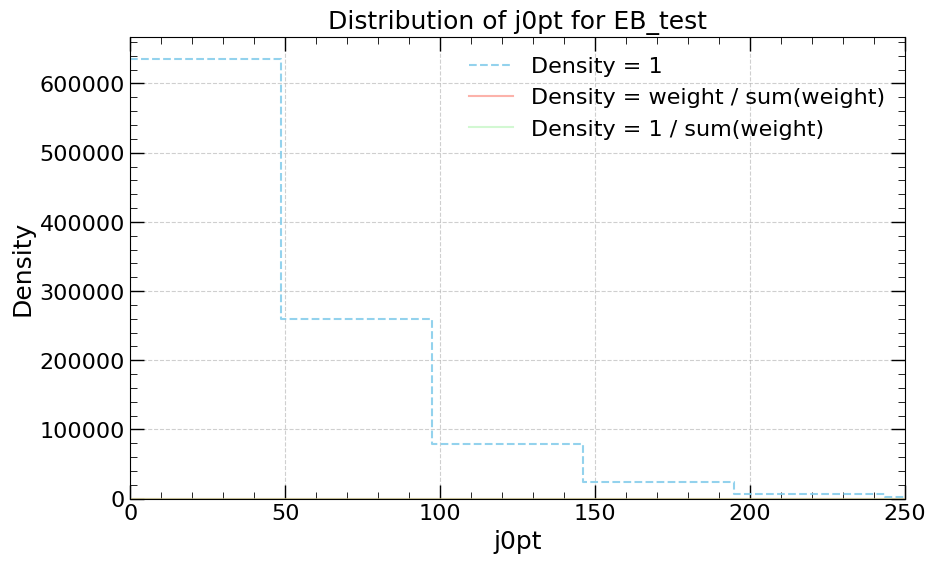

In [22]:
plot_weighted_distributions(combined_hlt_df, 'EB_test', 'j0pt',nbins=200)

In [23]:
def plot_weighted_distributions(df, target_name, variable, nbins=100, x_max=None):
    """
    Plots weighted and unweighted distributions of a variable for a given target using matplotlib.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        target_name (str): The name of the target class to filter.
        variable (str): The name of the variable to plot.
        nbins (int, optional): Number of bins to use in histograms. Default is 100.
        x_max (float, optional): Optional max x-axis value for non-eta/phi variables.
    """
    # Filter by target
    df_target = df[df['target'] == target_name].copy()

    if df_target.empty:
        print(f"No data found for target: {target_name}")
        return

    # Ensure weights are numeric and handle potential issues
    df_target['weight'] = pd.to_numeric(df_target['weight'], errors='coerce').fillna(0)
    # Keep rows even with zero weight for 'Density = 1' histogram if needed,
    # but for weighted density we should filter out zero weights.
    df_target_weighted = df_target[df_target['weight'] > 0].copy()


    # --- Determine binning strategy based on variable name ---
    is_eta = 'eta' in variable.lower()
    is_phi = 'phi' in variable.lower()

    if is_eta:
        bins = np.linspace(-3.8, 3.8, nbins + 1)
    elif is_phi:
        bins = np.linspace(-4.5, 4.5, nbins + 1)
    else:  # typical pt-like variable
        # Use the max value from the filtered data for binning if x_max is not provided
        data_max = df_target[variable].max() if not df_target.empty else 0
        if x_max is not None:
            bins = np.linspace(0, x_max, nbins + 1)
        elif data_max > 0:
             bins = np.linspace(0, data_max, nbins + 1)
        else: # Handle case where all values are 0 or df is empty
             bins = nbins # Default matplotlib binning (auto)


    # --- Create figure ---
    plt.figure(figsize=(10, 6))

    # --- Plot weighted and unweighted distributions using matplotlib ---

    # Unweighted distribution (Density = 1)
    if not df_target.empty:
        plt.hist(
            df_target[variable], bins=bins, density=True, histtype='step',
            label='Unweighted counts', color='skyblue', alpha=0.6
        )

    # Weighted distribution (Density proportional to weight)
    if not df_target_weighted.empty:
         plt.hist(
            df_target_weighted[variable], bins=bins, weights=df_target_weighted['weight'],
            density=True, histtype='step',
            label='Weighted counts', color='salmon', alpha=0.6
        )

    # Set log scale for axes
    # plt.xscale('log') # Uncomment if you want log scale on x-axis
    plt.yscale('log')


    # --- Final formatting ---
    plt.title(f'Distribution of {variable} for {target_name}')
    plt.xlim(bins[0], 250)
    plt.xlabel(variable)
    plt.ylabel('Counts (log scale)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

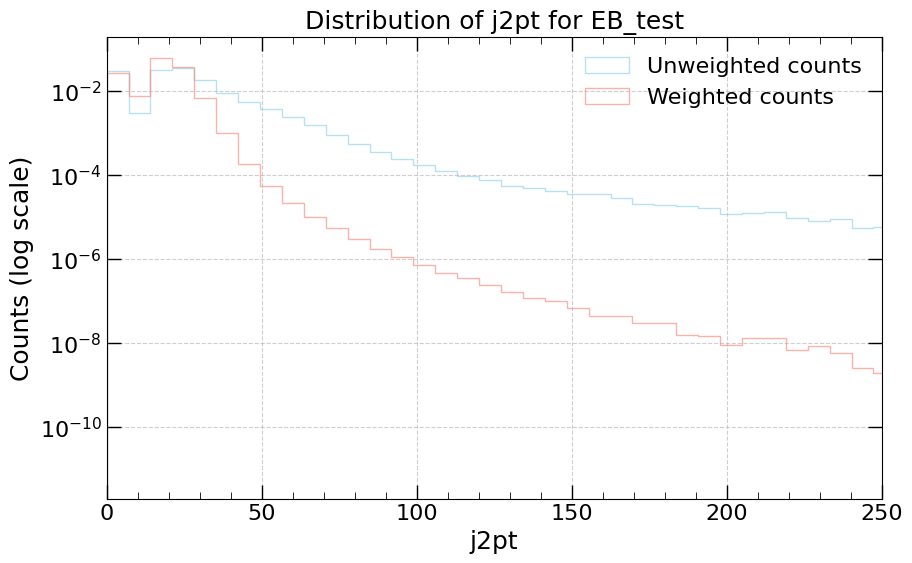

In [24]:
plot_weighted_distributions(combined_hlt_df, 'EB_test', 'j2pt',nbins=100)

In [32]:
def plot_weighted_distributions(df, target_name, variable, nbins=70, norm=False):
    """
    Plots weighted and unweighted distributions of a variable for a given target.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        target_name (str): The name of the target class to filter.
        variable (str): The name of the variable to plot.
        norm (bool): Whether to normalize the histogram.
    """
    # Filter by target
    df_target = df[df['target'] == target_name].copy()

    if df_target.empty:
        print(f"No data found for target: {target_name}")
        return

    # Ensure weights are numeric and handle potential issues
    df_target['weight'] = pd.to_numeric(df_target['weight'], errors='coerce').fillna(0)
    df_target = df_target[df_target['weight'] > 0].copy()  # Filter out zero weights if any

    if df_target.empty:
        print(f"No weighted data found for target: {target_name}")
        return

    sum_w = df_target['weight'].sum()
    n_events = len(df_target)

    if sum_w == 0 or n_events == 0:
        print(f"Insufficient data for plotting for target: {target_name}")
        return

    # Compute weights for each distribution
    weights_density_1 = np.ones_like(df_target[variable])                # Density = 1
    weights_density_w_sum_w = df_target['weight'] / sum_w                # Density = weight / sum(weight)
    weights_density_1_sum_w = np.ones_like(df_target[variable]) / sum_w  # Density = 1 / sum(weight)
    weights_none = None                                                  # Raw unweighted histogram

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot histograms
    # plt.hist(
    #     df_target[variable],
    #     bins=nbins,
    #     weights=weights_density_1,
    #     density=norm,
    #     histtype='step',
    #     color='skyblue',
    #     alpha=0.9,
    #     label='weights = 1',
    #     linestyle='--',
    #     linewidth=1.7
    # )

    # plt.hist(
    #     df_target[variable],
    #     bins=nbins,
    #     weights=weights_density_w_sum_w,
    #     density=norm,
    #     histtype='step',
    #     color='salmon',
    #     alpha=0.6,
    #     label='Density = weight / sum(weight)'
    # )

    # plt.hist(
    #     df_target[variable],
    #     bins=nbins,
    #     weights=weights_density_1_sum_w,
    #     density=norm,
    #     histtype='step',
    #     color='lightgreen',
    #     alpha=0.4,
    #     label='Density = 1 / sum(weight)'
    # )

    plt.hist(
        df_target[variable],
        bins=nbins,
        weights=df_target['weight'],
        density=norm,
        histtype='step',
        color='yellow',
        alpha=0.7,
        label='weights'
    )

    # Final formatting
    plt.xlim(-0.1, 250)
    plt.title(f'Distribution of {variable} for {target_name}')
    plt.xlabel(variable)
    plt.ylabel('Counts')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


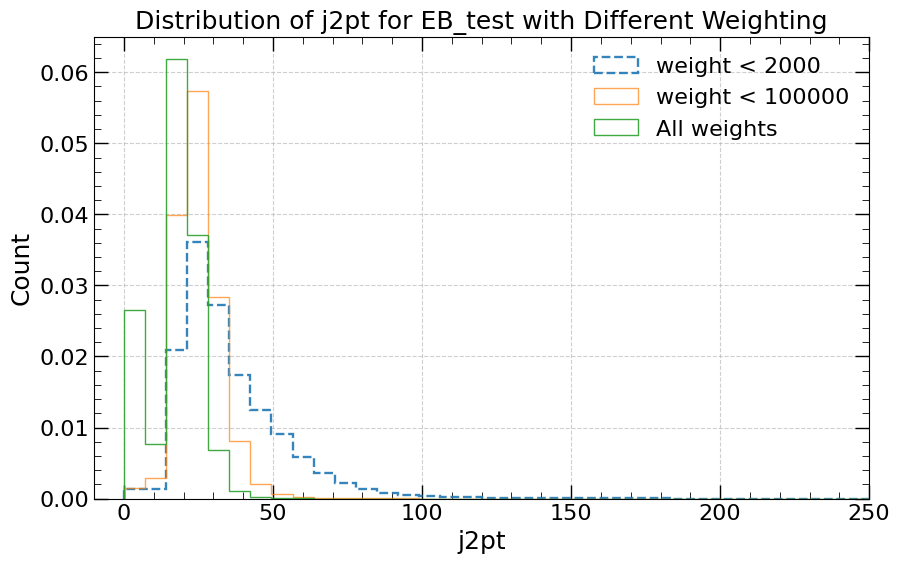

In [52]:
# Filter by target to get the base DataFrame for plotting all events
df_target = combined_hlt_df[combined_hlt_df['target'] == 'EB_test'].copy()

# Create weight arrays based on conditions
weights_all = df_target['weight'].values
weights_lt_2k = weights_all * (weights_all < 2000)
weights_lt_10k = weights_all * (weights_all < 100000)

# Determine binning (using j2pt variable for example)
variable = 'j2pt'
nbins = 100
# Use the max value from the all weights data for binning
data_max = df_target[variable].max() if not df_target.empty else 0
if data_max > 0:
     bins = np.linspace(0, data_max, nbins + 1)
else:
     bins = nbins

# Create figure
plt.figure(figsize=(10, 6))

# Plot histograms using different weight arrays
plt.hist(df_target[variable], bins=bins, weights=weights_lt_2k, histtype='step', label='weight < 2000', alpha=0.9, density=True, linestyle='--', linewidth=1.7)
plt.hist(df_target[variable], bins=bins, weights=weights_lt_10k, histtype='step', label='weight < 100000', alpha=0.7, density=True)
plt.hist(df_target[variable], bins=bins, weights=weights_all, histtype='step', label='All weights', alpha=0.9, density=True)

# Option for log scale on y-axis
log_y = False  # Set to True to enable log scale, False for linear scale
if log_y:
    plt.yscale('log')
    plt.ylabel('Count (log scale)')
else:
    plt.ylabel('Count')
    plt.xlim(-10,250)


# Final formatting
plt.title(f'Distribution of {variable} for EB_test with Different Weighting')
plt.xlabel(variable)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

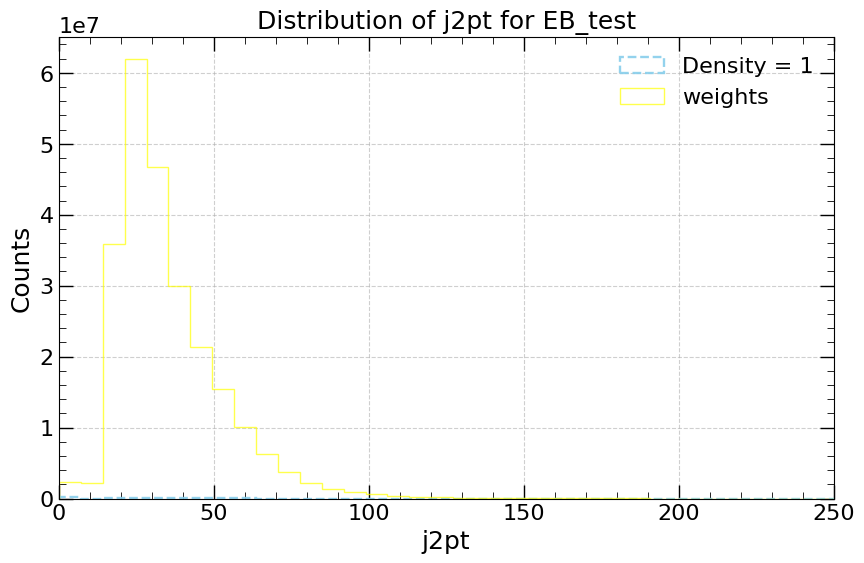

In [27]:
plot_weighted_distributions(combined_hlt_df[combined_hlt_df['weight'] < 2000], 'EB_test', 'j2pt',nbins=100, norm=False)

In [28]:
def plot_pt_distributions_with_limits(df, columns_to_plot, x_limit, log_y=False, value_limit=None):
    """
    Plots distributions of specified 'pt' columns with defined x-axis limits and optional log scale y-axis using matplotlib.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        columns_to_plot (list): A list of column names to plot.
        x_limit (tuple): A tuple (min, max) for the x-axis limits.
        log_y (bool, optional): If True, set the y-axis to a log scale. Default is False.
        value_limit (float, optional): If provided, filter values in each column to be less than this limit before plotting.
    """
    import re
    import matplotlib.pyplot as plt

    num_cols = len(columns_to_plot)
    n_cols = 4  # Number of columns in the subplot grid
    n_rows = (num_cols + n_cols - 1) // n_cols  # Number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), dpi=130)
    axes = axes.flatten()

    # Define colors for different object types
    color_map = {
        'j': 'blue',
        'e': 'green',
        'mu': 'red',
        'ph': 'purple',
        'MET': 'orange'
    }

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]

        # Extract prefix before first digit (e.g. 'j0pt' -> 'j')
        object_type = re.match(r'^[A-Za-z]+', col)
        object_type = object_type.group(0) if object_type else ''
        color = color_map.get(object_type, 'gray')

        # Filter data if needed
        if value_limit is not None:
            filtered_data = df[df[col] < value_limit][col]
        else:
            filtered_data = df[col]

        ax.hist(filtered_data, bins=10, range=x_limit, color=color, alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {col}')
        ax.set_xlim(x_limit)
        if log_y:
            ax.set_yscale('log')
            ax.set_ylabel('Count (log scale)')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Hide unused subplots
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


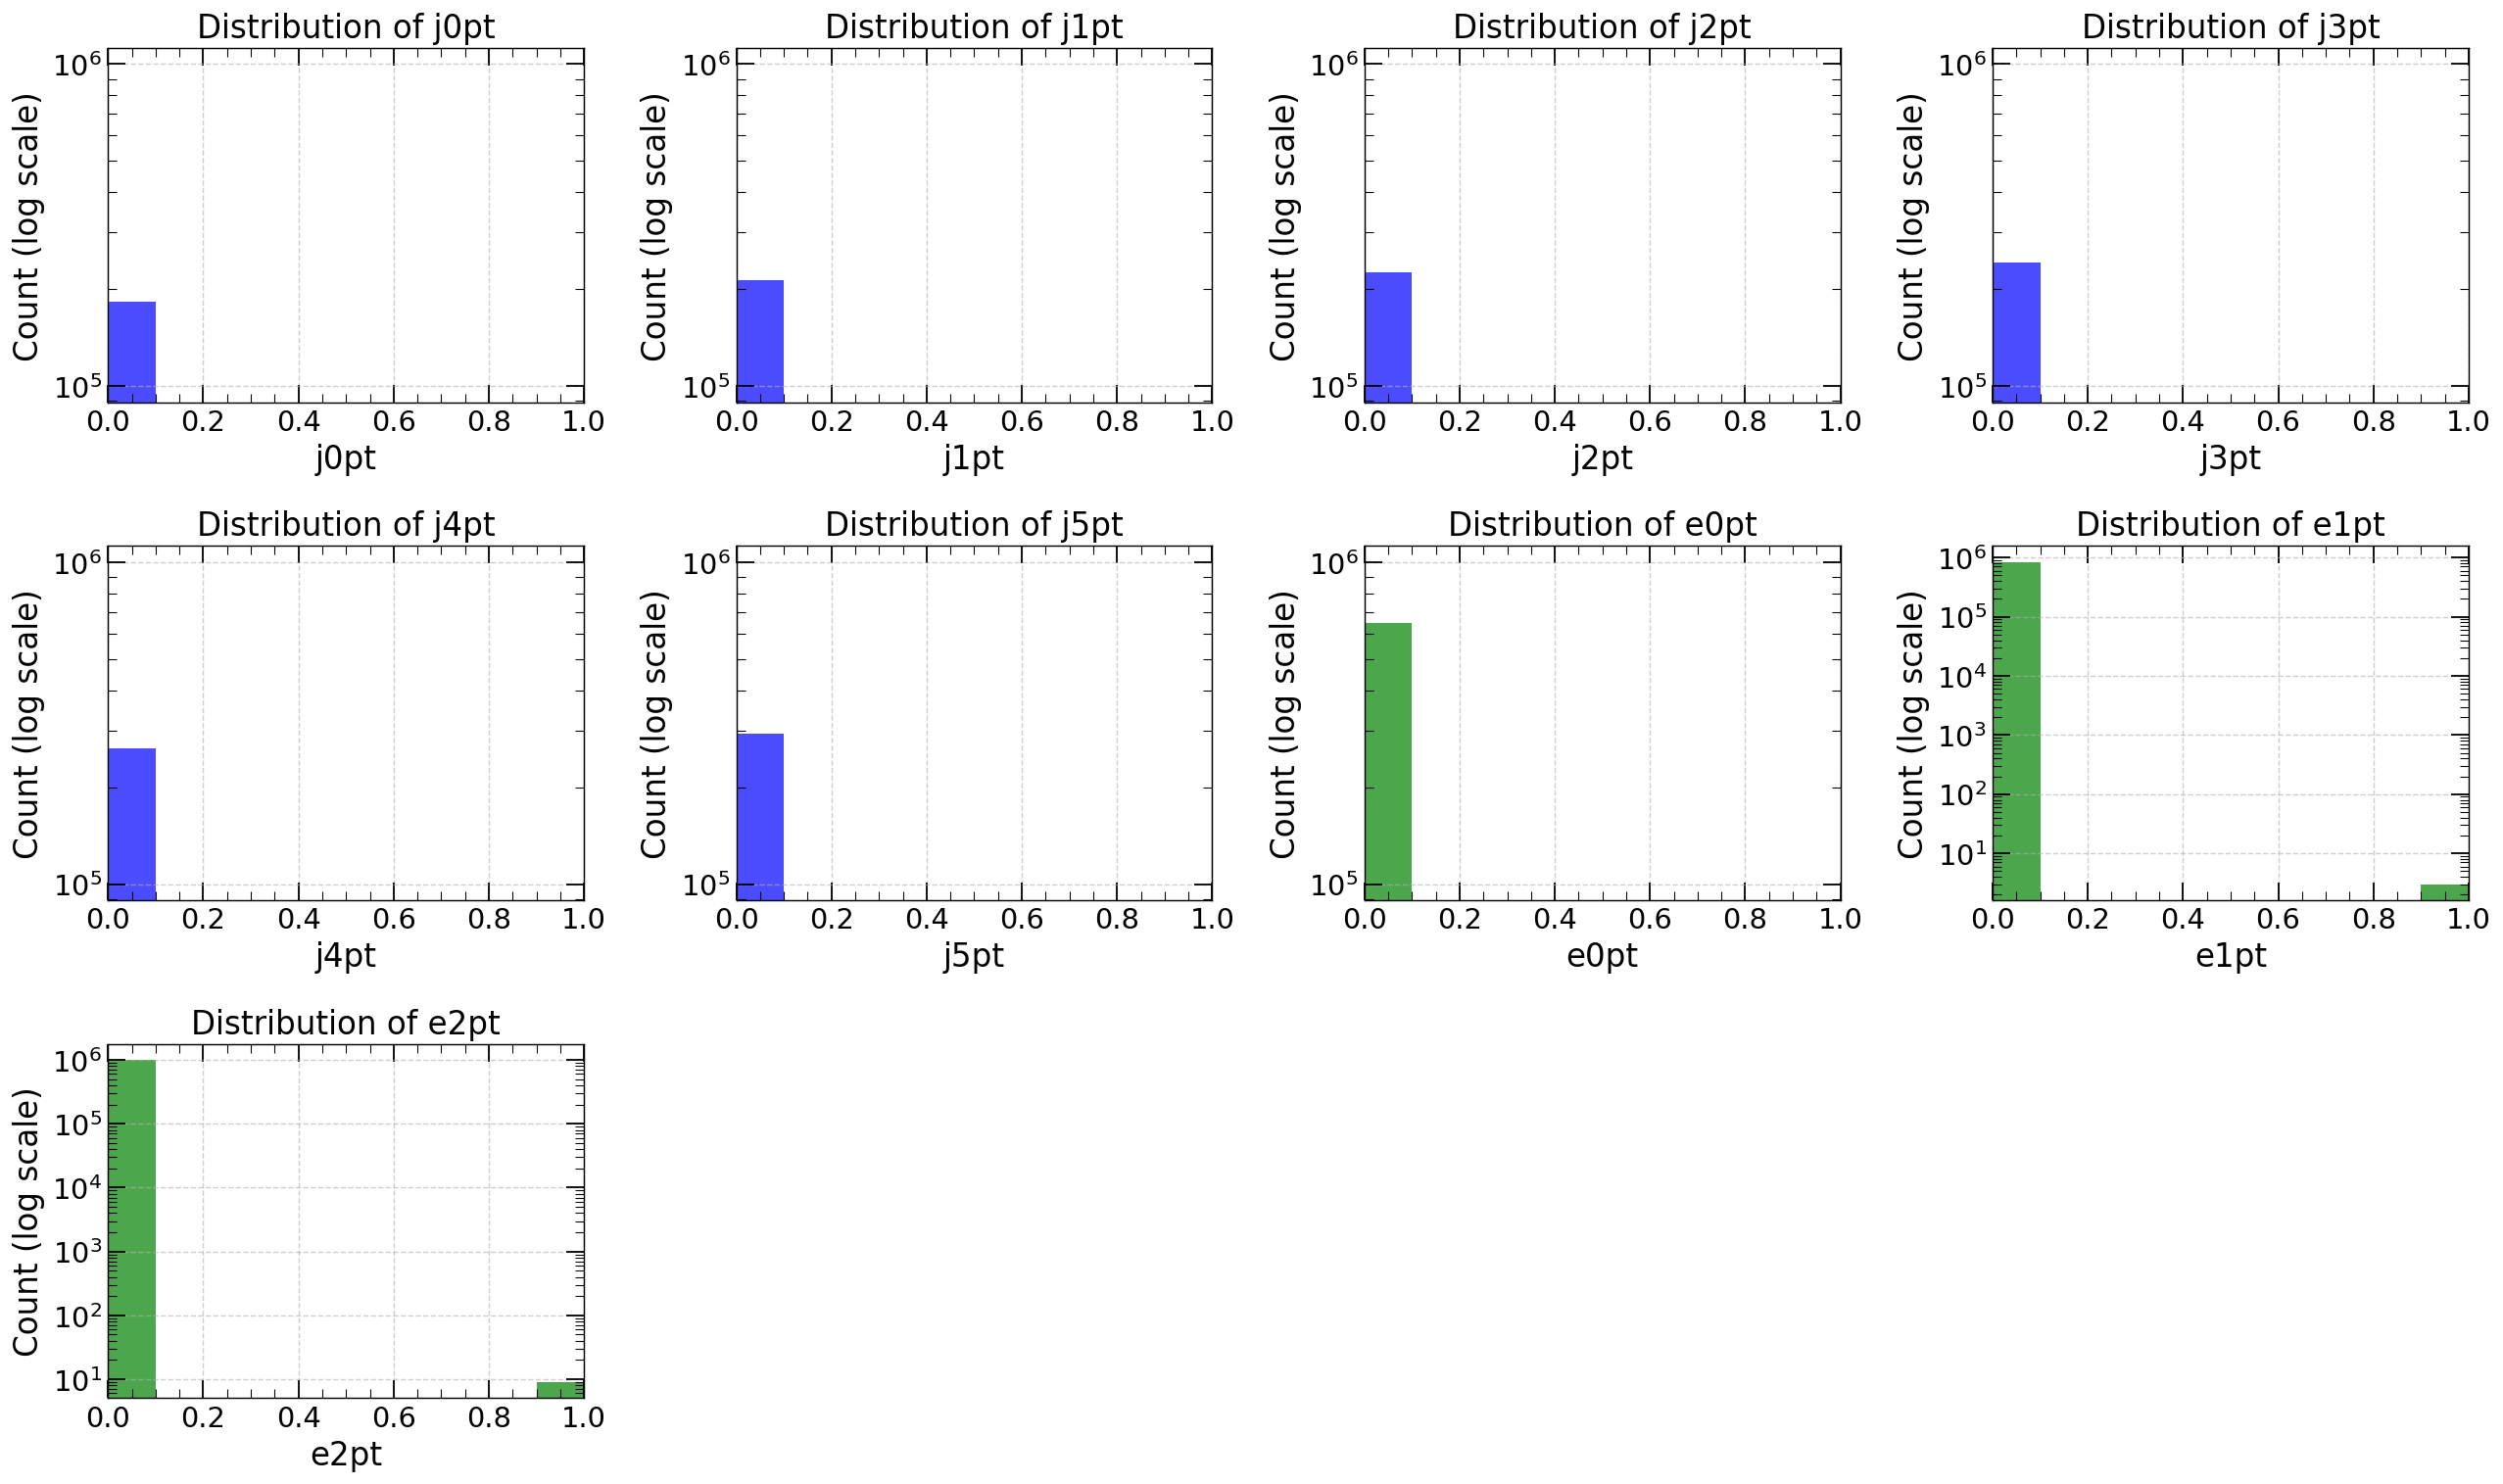

In [29]:
low_xlim_cols = [c for c in combined_hlt_df[combined_hlt_df['target'] == target_name].columns if ('j' in c or 'e' in c) and 'pt' in c]
plot_pt_distributions_with_limits(combined_hlt_df, low_xlim_cols, x_limit=(0, 1), log_y=True)

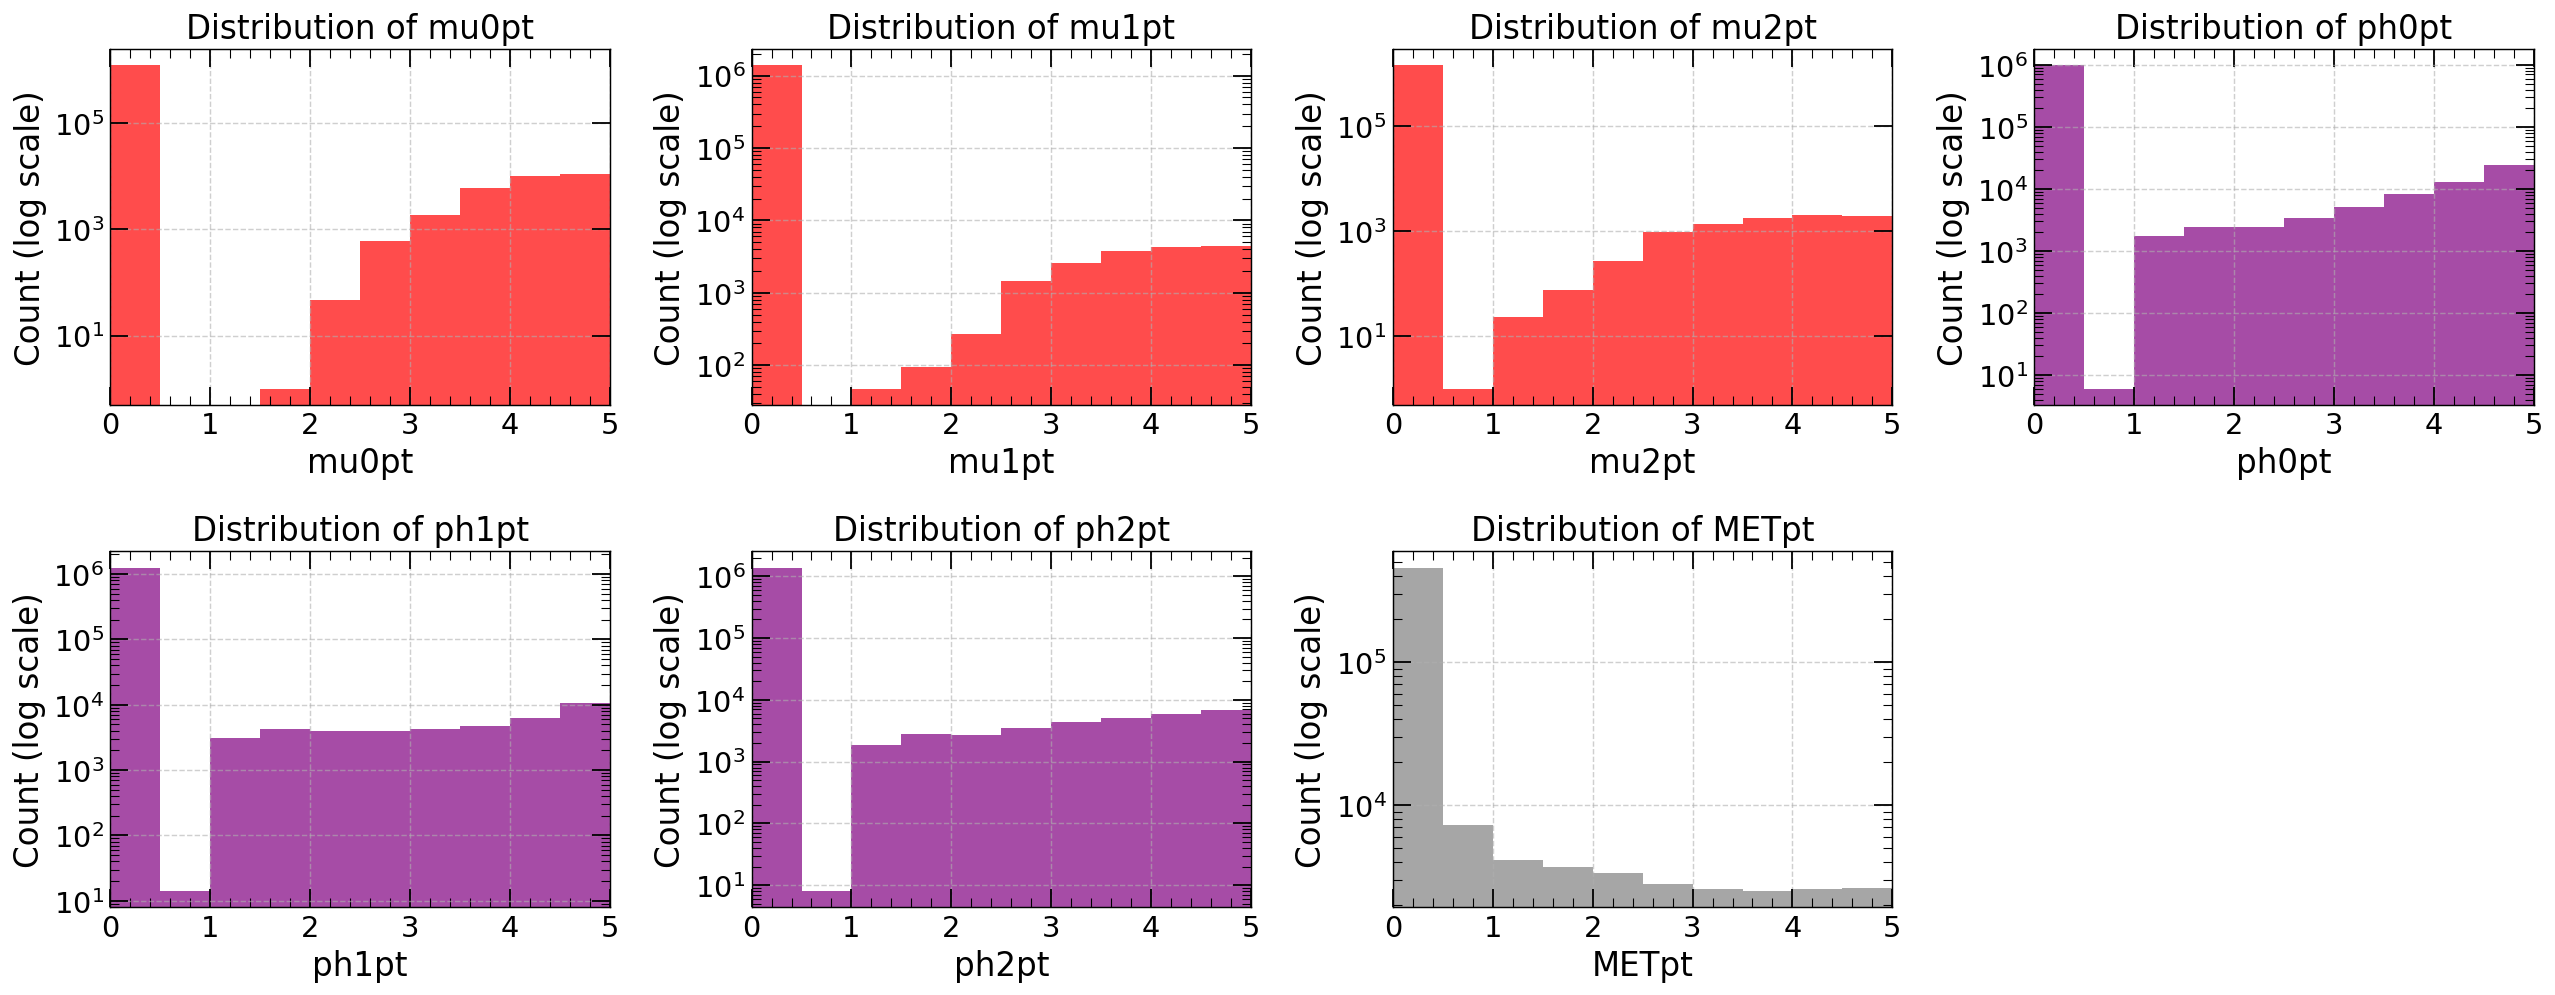

In [30]:
high_xlim_cols = [c for c in combined_hlt_df[combined_hlt_df['target'] == target_name].columns if ('mu' in c or 'ph' in c or 'MET' in c) and 'pt' in c]
plot_pt_distributions_with_limits(combined_hlt_df, high_xlim_cols, x_limit=(0, 5), log_y=True)

In [31]:
# Lists of the plotted columns
low_xlim_cols = [c for c in combined_hlt_df.columns if ('j' in c or 'e' in c) and 'pt' in c]
high_xlim_cols = [c for c in combined_hlt_df.columns if ('mu' in c or 'ph' in c or 'MET' in c) and 'pt' in c]
all_plotted_cols = low_xlim_cols + high_xlim_cols

# Print unique values for each column (first 5 values less than 10)
for col in all_plotted_cols:
    unique_values = combined_hlt_df[col].unique()
    print(f"Unique values for '{col}' (first 5 values < 5):")
    count = 0
    for value in unique_values:
        if value < 5:
            print(value)
            count += 1
            if count >= 5:
                break
    print("-" * 20, '\n')

Unique values for 'j0pt' (first 5 values < 5):
0.0
-------------------- 

Unique values for 'j1pt' (first 5 values < 5):
0.0
-------------------- 

Unique values for 'j2pt' (first 5 values < 5):
0.0
4.985384464263916
4.567503452301025
4.61709451675415
-------------------- 

Unique values for 'j3pt' (first 5 values < 5):
0.0
4.057325839996338
4.8336639404296875
-------------------- 

Unique values for 'j4pt' (first 5 values < 5):
0.0
3.777635335922241
3.2893781661987305
3.6484880447387695
3.755021333694458
-------------------- 

Unique values for 'j5pt' (first 5 values < 5):
0.0
4.397277355194092
4.4295477867126465
4.606247425079346
4.8056559562683105
-------------------- 

Unique values for 'e0pt' (first 5 values < 5):
0.0
3.7761223316192627
4.865190505981445
4.099095344543457
2.1314916610717773
-------------------- 

Unique values for 'e1pt' (first 5 values < 5):
0.0
3.100083351135254
1.8268091678619385
4.735793590545654
4.8699798583984375
-------------------- 

Unique values for 'e2p